# nacc dataset

### 1. Data cleaning

In [1]:
import tarfile
import pandas as pd
import numpy as np

In [2]:
# see if this is a tar file
# print(tarfile.is_tarfile("fs_t1_nacc.tar"))

tar = tarfile.open("fs_t1_nacc.tar")
# get a list of tarInfo objects
directory = tar.getmembers()
# extract names from the objects to get a directory list
directory = [file.name.split("/")[1] for file in directory if file.isfile()]
# 7862 files in total
image_info = pd.DataFrame(directory, columns=["filename"])
image_info["NACCMRFI"] = image_info["filename"].apply(
    lambda x: x.split("_")[0])
image_info.head()
# 5897 unique NACCMRFIs in total

,filename,NACCMRFI
0,mri71_MPRAGE_T1_AX_20100921133637_15.nii.gz,mri71
1,mri3579_t1_fl2d_sag_20100610142105_3.nii.gz,mri3579
2,mri4375_MPRAGE_20110105152454_2.nii.gz,mri4375
3,mri4908_SAG_T1_20130424203248_2.nii.gz,mri4908
4,mri1061_FSPGR_rhuser1=-376_rhuser2=10_20130620...,mri1061


In [3]:
# load data_nacc_diagnosis.csv to match the diagnosis with image data
clinic_info = pd.read_excel("data_nacc_diagnosis.xlsx")
clinic_info.head()

# remove columns we don't use
temp1 = clinic_info.iloc[:, 1:3]
temp1.head()

# check the duplicate situation, generate a list of indices to drop
temp2 = temp1.groupby("NACCMRFI").nunique()
# drop the conflicting-diagnoses cases: 12 cases removed
duplicates = temp2[temp2["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"] == 2].index
temp3 = temp1.set_index("NACCMRFI").drop(labels=list(duplicates), axis=0)
# drop normal duplicates, 81 cases removed
diag_info = temp3.reset_index().drop_duplicates()
# modify ID information
diag_info["NACCMRFI"] = diag_info["NACCMRFI"].apply(lambda x: x.split(".")[0])
diag_info.head()

,NACCMRFI,diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia
0,mri1140,0
1,mri5864,0
2,mri5863,0
3,mri4786,0
4,mri7855,0


In [4]:
# merge the two files and see the matching results
match_info = image_info.merge(
    diag_info, left_on="NACCMRFI", right_on="NACCMRFI", how="outer")
act_dataset_len = len(match_info[(match_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].isna(
) == False) & (match_info["filename"].isna() == False)])
whole_dataset_len = len(match_info)
print("There are %s data points in total." % whole_dataset_len)
print("Only %s can be matched to the diagnosis information which can be used as the dataset." % act_dataset_len)

# take all useful data points
data_info = match_info[(match_info["diagnosis_0normal_1normaltomci_2mci_3ad_4otherdementia"].isna(
) == False) & (match_info["filename"].isna() == False)]
# data_info.head(30)

There are 8836 data points in total.
Only 6272 can be matched to the diagnosis information which can be used as the dataset.


### 2. Apply the autoencoder

In [5]:
from nilearn import plotting
import os
import nibabel as nib
import tensorflow as tf

C:\Users\zhang\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
# tar.extract("fs_t1/mri1001_Coronal-MPRAGE_20090113091713_3.nii.gz")
# plotting.plot_img("fs_t1/mri1001_Coronal-MPRAGE_20090113091713_3.nii.gz")
# plotting.show()

# tar.extract("fs_t1/mri1001_Coronal-MPRAGE_20090113091713_3d.nii.gz")
# plotting.plot_img("fs_t1/mri1001_Coronal-MPRAGE_20090113091713_3d.nii.gz")
# plotting.show()

# tar.extract("fs_t1/mri1001_FSPGR_rhuser1=-376_rhuser2=10_20090113113423_3.nii.gz")
# plotting.plot_img("fs_t1/mri1001_FSPGR_rhuser1=-376_rhuser2=10_20090113113423_3.nii.gz")
# plotting.show()

# tar.extract("fs_t1/mri1001_FSPGR_rhuser1=-376_rhuser2=10_20090113113423_3d.nii.gz")
# plotting.plot_img("fs_t1/mri1001_FSPGR_rhuser1=-376_rhuser2=10_20090113113423_3d.nii.gz")
# plotting.show()

##### building a 3D convolutional layer

In [6]:
# load sample images
number_files_loaded = 3
sample_list = data_info.iloc[:number_files_loaded, :]["filename"]
sample_data_list = list()
for filename in sample_list:
    file = tar.extract("fs_t1/"+filename)
    # or is it better to use get_fdata()?
    a = nib.load("fs_t1/"+filename).get_data()
    sample_data_list.append(a)
sample_dataset = np.array(sample_data_list, dtype=np.float32)
batch_size, height, width, depth = sample_dataset.shape
channels = 1  # gray-scale instead of RGB
s = sample_dataset.reshape(3, 256, 256, 256, 1)

# create 3 filters (2 filters for 2D)
# kernel size is 7 here, might not be optimal
# filters = np.zeros(shape=(7, 7, 7, channels, 3), dtype=np.float32)
# filters[3, :, :, :, 0] = 1  # horizontal line
# filters[:, 3, :, :, 1] = 1  # vertical line
# filters[:, :, 3, :, 2] = 1  # another dimension line

# # create a 3D convolutional layer
# X = tf.placeholder(tf.float32, shape=(None, height, width, depth, channels))
# convolution = tf.nn.conv3d(X, filters, strides=[1, 4, 4, 4, 1], padding='SAME')

# with tf.Session() as sess:
#     output = sess.run(convolution, feed_dict={X: s})

In [ ]:
batch_size = 3
depth = 256
height = 256
width = 256
n_channels = 1
input_shape = (batch_size, depth, height, width, n_channels)
filters = (3,60,120)
# kernel_size = 
padding = "same"          # "valid" or "same"
activation = tf.nn.relu
stride = [4,4,4]


# start of tensorflow graph
 #input and target placeholders
inputs_ = tf.placeholder(tf.float32, input_shape, name='inputs')
# targets_ = tf.placeholder(tf.float32, input_shape, name='targets')


 #network 14
  #encoder
conv1 = tf.layers.conv3d(inputs= inputs_, filters=filters[0], kernel_size=(7,7,7), padding= padding, strides = stride, activation=tf.nn.relu)	
maxpool1 = tf.layers.max_pooling3d(conv1, pool_size=(8,8,8), strides=(8,8,8), padding= padding)
# conv2 = tf.layers.conv3d(inputs=maxpool1, filters=filters[1], kernel_size=(3,3,3), padding= padding, strides = stride, activation=tf.nn.relu)
# maxpool2 = tf.layers.max_pooling3d(conv2, pool_size=(2,2,2), strides=(2,2,2), padding= padding)
# conv3 = tf.layers.conv3d(inputs=maxpool2, filters=filters[2], kernel_size=(3,3,3), padding= padding , strides = stride, activation=tf.nn.relu)
# maxpool3 = tf.layers.max_pooling3d(conv3, pool_size=(4,4,4), strides=(4,4,4), padding= padding)
  #latent internal representation

  #decoder
# unpool1 = tf.keras.backend.resize_volumes(maxpool3,4,4,4,"channels_last")
# deconv1 = tf.layers.conv3d_transpose(inputs=unpool1, filters=filters[2], kernel_size=(3,3,3), padding= padding , strides = stride, activation=tf.nn.relu)
# unpool2 = tf.keras.backend.resize_volumes(maxpool2,2,2,2,"channels_last")
# deconv2 = tf.layers.conv3d_transpose(inputs=unpool2, filters=filters[1], kernel_size=(3,3,3), padding= padding , strides = stride, activation=tf.nn.relu)
unpool3 = tf.keras.backend.resize_volumes(maxpool1,8,8,8,"channels_last")
deconv3 = tf.layers.conv3d_transpose(inputs=unpool3, filters=filters[0], kernel_size=(7,7,7), padding= padding , strides = stride, activation=tf.nn.relu)

# output = tf.layers.dense(inputs=deconv3, units=1)
# output = tf.reshape(output, input_shape)
  # output shape = input shape


  #loss function, optimizer and a saver to save weights&biases
# loss = tf.divide(tf.norm(tf.subtract(targets_, output), ord = 'fro', axis = [1,2,3]), tf.norm(targets_, ord = 'fro', axis = [1,2,3]))
# cost = tf.reduce_mean(loss)
# opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
# all_saver = tf.train.Saver(max_to_keep = None)

init_op = tf.global_variables_initializer()

# sess = tf.Session()
# sess.run(init_op)

with tf.Session() as sess:
    sess.run(init_op)
#     decode_output = sess.run(maxpool3, feed_dict={inputs_: s})
    encode_output = sess.run(deconv3, feed_dict={inputs_: s})

In [42]:
decode_output.shape

(3, 8, 8, 8, 120)

In [43]:
encode_output.shape

(3, 32, 32, 32, 120)

In [8]:
def layer_batch_normalization(x, n_out, phase_train):
    """
    Defines the network layers
    input:
        - x: input vector of the layer
        - n_out: integer, depth of input maps - number of sample in the batch 
        - phase_train: boolean tf.Varialbe, true indicates training phase
    output:
        - batch-normalized maps   
    
    
    """

    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)

    #tf.nn.moment: https://www.tensorflow.org/api_docs/python/tf/nn/moments
    #calculate mean and variance of x
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    
    #tf.train.ExponentialMovingAverage:
    #https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage
    #Maintains moving averages of variables by employing an exponential decay.
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
        
    #tf.cond: https://www.tensorflow.org/api_docs/python/tf/cond
    #Return true_fn() if the predicate pred is true else false_fn()
    mean, var = tf.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))

    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    
    return tf.reshape(normed, [-1, n_out])

In [ ]:
layer_batch_normalization(x, n_out, phase_train)

In [ ]:
def layer(x, weight_shape, bias_shape, phase_train):
    
    """
    Defines the network layers
    input:
        - x: input vector of the layer
        - weight_shape: shape the the weight maxtrix
        - bias_shape: shape of the bias vector
        - phase_train: boolean tf.Varialbe, true indicates training phase
    output:
        - output vector of the layer after the matrix multiplication and non linear transformation
    """
    
    #initialize weights
    weight_init = tf.random_normal_initializer(stddev=(1.0/weight_shape[0])**0.5)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    
    bias_init = tf.constant_initializer(value=0)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)

    logits = tf.matmul(x, W) + b
    
    #apply the non-linear function after the batch normalization
    return tf.nn.sigmoid(layer_batch_normalization(logits, weight_shape[1], phase_train))

In [8]:
output.shape

(5, 64, 64, 64, 3)

In [9]:
batch, xs, ys, zs, channels = output

In [10]:
output[0, :, :, :, 1].shape

(64, 64, 64)

IndexError: index 128 is out of bounds for axis 2 with size 32

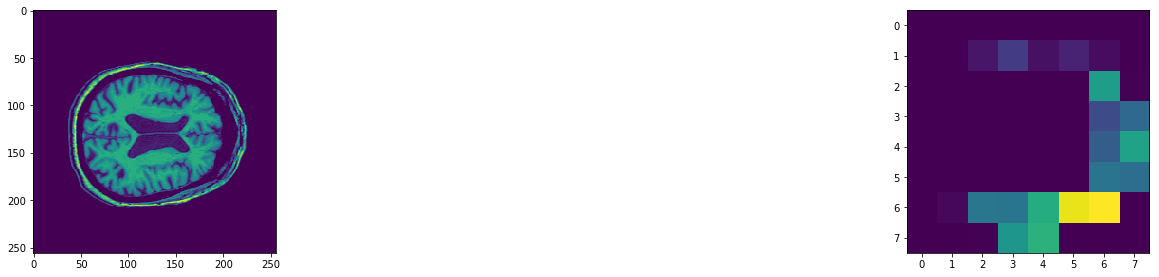

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

w = 10
h = 10
fig = plt.figure(figsize=(20, 20))
columns = 4
rows = 1
# for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img)
img = s[0, :, 128, :, 0]
fig.add_subplot(rows, columns, 1)
plt.imshow(img)

# img = output[0, :, 4, :, 0]
# fig.add_subplot(rows, columns, 2)
# plt.imshow(img)

# img = output[0, :, 4, :, 1]
# fig.add_subplot(rows, columns, 3)
# plt.imshow(img)

img = decode_output[0, :, 4, :, 60]
fig.add_subplot(rows, columns, 4)
plt.imshow(img)

img = encode_output[0, :, 128, :, 0]
fig.add_subplot(rows, columns, 1)
plt.imshow(img)

plt.show()

In [69]:
"""
tf.nn.conv3d(
    input,
    filter,
    strides,
    padding,
    data_format='NDHWC',
    name=None
    
    
    input = x 
    filter = W 
    stride = [1,1,1,1,1]
    padding='SAME'
    
) """


def module_conv3d(x, weight_shape, bias_shape):
    print(weight_shape)
    sizeIn = weight_shape[0] * weight_shape[1] * weight_shape[2]

    weight_init = tf.random_normal_initializer(stddev=(2.0/sizeIn)**0.5)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    # initialize bias with zeros
    bias_init = tf.constant_initializer(value=0)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv3d(x, W, strides=[1, 1, 1, 1, 1], padding='SAME'), b))

In [51]:
s.shape

(100, 256, 256, 256, 1)

In [52]:
s_1 = s[0].reshape(256, 256, 256)

In [39]:
s_new.shape

(100, 256, 256, 256, 1)

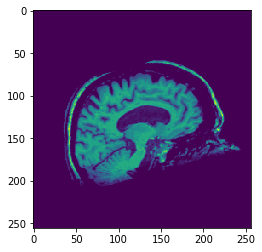

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(s_1[120].astype(np.uint8))

In [55]:
a = [0,102,9]
a[0] = 1
a

[1, 102, 9]